In [1]:
import random
import pandas as pd
import numpy as np
import math
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
import statsmodels.api as sm
import statsmodels.stats.diagnostic as tds
from statsmodels.api import add_constant
from scipy import stats

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df1 = pd.read_csv('sp200_data_.csv', header = 0 )
df1.head()

n_stocks = df1.Name.nunique()
n_factors = len(df1.columns) - len(['Date', 'Name', 'Px_LAST', 'CUR_MKT_CAP', 'Return']) # List of non-factor columns in data

print("\nNumber of stocks:",n_stocks)
print("Number of stocks:",n_factors)

# Benchmark and Risk-free Rate data

bench = pd.read_csv('sp500_ret.csv', header = 0 )
bench.head()
rf = pd.read_csv('risk_free_ret.csv', header = 0 )
rf.head() 

# Clean Data

df1 = df1.apply(pd.to_numeric, errors='coerce')
df1 = df1.fillna( 0.0 )
df1 = df1.replace('#VALUE!',0.0)
df1 = df1.replace('#DIV/0!',0.0)
df1 = df1.replace('#N/A',0.0)
df1 = df1.replace('#N/A N/A',0.0)
df1 = df1.replace('#N/A N/A ',0.0) 
df1 = df1.replace(' ',0.0)                   

# Split data for training and testing

test_size = 0.20
n_test_obs = int(math.ceil(len(df1.index)*test_size)) # this rounds up

X = np.delete( df1.values, [0,1,2,3,10] , axis = 1 )
y = np.delete( df1.values, [0,1,2,3,4,5,6,7,8,9], axis= 1 )

X_train_orig, X_test_orig, y_train, y_test = model_selection.train_test_split( X, y.ravel(), test_size = 0.20, shuffle = False )

train_periods = int(len(df1.index)/n_stocks*(1-test_size))  # this rounds down
#train_periods = 24

# Fix random seed for reproducibility

seed = 7
np.random.seed(seed)


Number of stocks: 218
Number of stocks: 6


In [4]:
x_mean = []
x_std = []

for i in range(0,n_factors):
    x_mean.append(np.mean(X_train_orig[:,i]))
    x_std.append(np.std(X_train_orig[:,i]))
    
X_train = X_train_orig
X_test = X_test_orig    

for j in range(0,n_factors):
    X_train[:,j] = (X_train_orig[:,j] - x_mean[j])/x_std[j]
    X_test[:,j] = (X_test_orig[:,j] - x_mean[j])/x_std[j]
    
"""
  Setting up predictive model, NN and Linear Regression. Choose the one to use and comment the other one
"""

print("Start time:\n", str(datetime.now()))

# Sklearn LinearRegression:

#print "\nUsing Linear Regression\n"
#lm = LinearRegression(fit_intercept = False)        # This line defines a linear predictive model

# NN using sklearn wrapper

#def baseline_model():
#	# create model
#	model = Sequential()
#	model.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='linear'))
#	model.add(Dense(1, kernel_initializer='normal')) # output layer
#	# Compile model
#	model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
#	return model

Start time:
 2018-11-14 21:19:43.380958


In [5]:
def NN1_model(n_hidden_neurons=10, l1_reg=0.1):    
    model = Sequential()
    model.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(n_hidden_neurons, input_dim=6, kernel_initializer='normal',kernel_regularizer=l1(l1_reg), activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    return model

print("\nUsing Neural Networks, hidden neurons=1, l1_reg=0, epochs=40, batch_size=22\n")
lm = KerasRegressor(build_fn=NN1_model, epochs=40, batch_size=22, verbose=0)  # This line defines a NN predictive model


Using Neural Networks, hidden neurons=1, l1_reg=0, epochs=40, batch_size=22



In [6]:
# Normalizing Data:

# Using sklearn normalizer

#norm = preprocessing.Normalizer().fit(X_train_orig)
#X_train = norm.transform(X_train_orig)
#X_test = norm.transform(X_test_orig)

# Regular normalizer: calculate mean and std from train to normalize test

x_mean = []
x_std = []

for i in range(0,n_factors):
    x_mean.append(np.mean(X_train_orig[:,i]))
    x_std.append(np.std(X_train_orig[:,i]))
    
X_train = X_train_orig
X_test = X_test_orig    

for j in range(0,n_factors):
    X_train[:,j] = (X_train_orig[:,j] - x_mean[j])/x_std[j]
    X_test[:,j] = (X_test_orig[:,j] - x_mean[j])/x_std[j]
    
"""
  Setting up predictive model, NN and Linear Regression. Choose the one to use and comment the other one
"""

print("Start time:\n", str(datetime.now()))

Start time:
 2018-11-14 21:20:20.417563


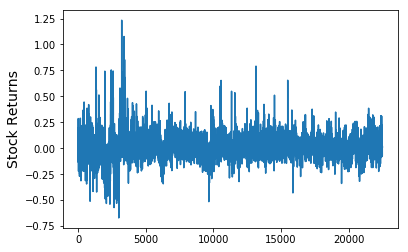

Factor Correlation Matrix:


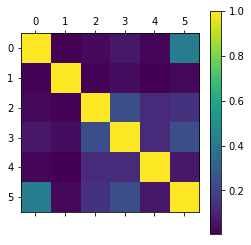

In [8]:
"""
Goodnes-of-fit Statistics
"""

plt.plot(y_train)
plt.ylabel('Stock Returns', fontsize = 14)
plt.show()

factors_ = df1[['CURR_ENTP_VAL', 'PX_TO_BOOK_RATIO', 'CURRENT_EV_TO_T12M_EBITDA', 'PX_TO_SALES_RATIO', 'PE_RATIO', 'Log_CAP']].copy()
print("Factor Correlation Matrix:")
plt.matshow(factors_.corr())
plt.colorbar()
plt.show()

In [9]:
def NN1_model(n_hidden_neurons=10, l1_reg=0.1):    
    model = Sequential()
    model.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(n_hidden_neurons, input_dim=6, kernel_initializer='normal',kernel_regularizer=l1(l1_reg), activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    return model

print("\nUsing Neural Networks, hidden neurons=1, l1_reg=0, epochs=40, batch_size=22\n")
lm = KerasRegressor(build_fn=NN1_model, epochs=40, batch_size=22, verbose=0)  # This line defines a NN predictive model


Using Neural Networks, hidden neurons=1, l1_reg=0, epochs=40, batch_size=22



In [12]:
"""
 Cross-sectional regression over time
"""

mse_cs = []
mse_insample = []
mae_cs = []
mae_insample = []
predictions_cs = []
predictions_insample = []
predictions_insample_set = []
coefficients = []
r2 = [] 
slice_ = []
prediction_set = []
p_values = []

for k in range(0,n_stocks*train_periods,n_stocks):
    print(k)
    lm.fit(X_train[k:k+n_stocks,:],y_train[k:(k+n_stocks)])
    
    #slice_1 = len(X_train[k:k+218])
    #print 'slice1:', slice_1
    predictions_cs = lm.predict(X_train[(k+n_stocks):(k+n_stocks*2),:])  
    prediction_set.append(predictions_cs)
   
    ols_results = sm.OLS(y_train[k:(k+n_stocks)], X_train[k:k+n_stocks,:]).fit()
    p_values.append(ols_results.pvalues[0:5])

    #slice_2 = len(X_train[k+218:k+436])
    #print 'slice 2:', slice_2
    predictions_insample = lm.predict(X_train[k:(k+n_stocks),:])
    predictions_insample_set.append(predictions_insample) 
    
    mse_cs.append(mean_squared_error(y_train[(k+n_stocks):(k+n_stocks*2)],predictions_cs))
    mse_insample.append(mean_squared_error(y_train[k:(k+n_stocks)],predictions_insample))
    
    mae_cs.append(mean_absolute_error(y_train[(k+n_stocks):(k+n_stocks*2)],predictions_cs))
    mae_insample.append(mean_absolute_error(y_train[k:(k+n_stocks)],predictions_insample))
    #coefficients.append(lm.coef_) # comment this if using NN 


0
218


KeyboardInterrupt: 

In [15]:
k=0
np.shape(X_train)

(22497, 6)

In [17]:
np.shape(X_train)[1]

6

In [47]:
# perturbations
eps=1e-3
dys = []
dys_sd = []
y=lm.predict(X_train[k:(k+n_stocks),:])
for i in range(np.shape(X_train)[1]):
    X_train_prime= X_train[k:(k+n_stocks),:]
    X_train_prime[:,i]+=eps
    y_prime = lm.predict(X_train_prime)
    dys.append(np.mean((y_prime-y)/y))
    dys_sd.append(np.std((y_prime-y)/y))
        

In [50]:
np.array(dys)/1e-7

array([-0.97534394, -0.723461  , -1.3596709 , -0.5005999 ,  0.4779428 ,
        0.9817639 ], dtype=float32)

In [35]:
factors= ['EV', 'P/B', 'EV/T12M EBITDA', 'P/S' , 'P/E','Log CAP']

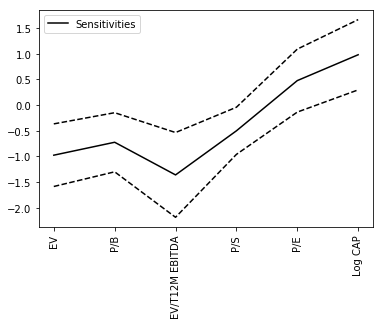

In [56]:
plt.plot(np.array(dys)/1e-7, color = 'black', label = 'Sensitivities')
plt.plot((np.array(dys)+ np.array(dys_sd))/1e-7, color = 'black', linestyle='--')
plt.plot((np.array(dys)- np.array(dys_sd))/1e-7, color = 'black', linestyle='--')
plt.xticks(range(6), factors, rotation='vertical') 
#plt.xticks(factors)
#plt.plot(mse_insample, color = 'black', label = "MSE In-Sample")
plt.legend()
plt.show()

In [ ]:
#copy variables
mse_cs_NN_10N_l1_01 =  mse_cs
mse_insample_NN_10N_l1_01 =  mse_insample
mae_cs_NN_10N_l1_01 =  mae_cs
mae_insample_NN_10N_l1_01 = mae_insample

In [ ]:

#print "Coefficients for first period:", coefficients[1] # comment this if using NN
#print "\nP-values for first period:\n", p_values[1]
print("\nMSE in-sample:", np.mean(mse_insample))
print("MSE out-of-sample:", np.mean(mse_cs))
plt.plot(mse_cs, color = 'red', label = 'MSE out-of-sample')
plt.plot(mse_insample, color = 'black', label = "MSE In-Sample")
plt.legend()
plt.show()

print("\nMAE in-sample:", np.mean(mae_insample))
print("MAE out-of-sample:", np.mean(mae_cs))
plt.plot(mae_cs, color = 'red', label = 'MAE out-of-sample')
plt.plot(mae_insample, color = 'black', label = "MAE In-Sample")
plt.legend()
plt.show()

In [ ]:
prediction_list = [item for sublist in prediction_set for item in sublist]      # "flatten" a list of list to a single list
y_true = y[218:(len(df1.index)-n_test_obs),]
y_true_list = [item for sublist in y_true for item in sublist]
residuals = np.subtract(y_true_list , prediction_list)
plt.hist(residuals, bins = 50) 
plt.ylabel('Residuals Histogram', fontsize = 12)
plt.show()

residuals_monthly = []
for p in range(0,n_stocks*train_periods,n_stocks):
    residuals_monthly.append(residuals[p:(p+n_stocks)])
    
#ljung_box_test = tds.acorr_ljungbox(residuals_monthly[:], lags=None, boxpierce=True)

#copy variables
residuals_NN_10N_l1_01 = residuals
residuals_monthly_NN_10N_l1_01 = residuals_monthly

In [ ]:
"""
 Information Ratio Calculation
"""    

info_ratio = []
info_ratio_is = []
info_ratio_wn = []

for m in [10,15,20,25]:
    excess_returns = []
    excess_returns_is = []
    excess_returns_wn = []
    excess_returns_std = []
    excess_returns_std_is = []
    excess_returns_std_wn = []
    idx = []
    idx_is = []
    for u in range(0,train_periods,1):
        idx.append(np.argsort(-prediction_set[u])[:m])
        pred_port = y[n_stocks*u+idx[u]]
        pred_port_ret = np.mean(pred_port)
        excess_returns.append((pred_port_ret - bench['Return'][u]))
        
        idx_is.append(np.argsort(-predictions_insample_set[u])[:m])
        pred_port_is = y[n_stocks*u+idx_is[u]]
        pred_port_ret_is = np.mean(pred_port_is)
        excess_returns_is.append((pred_port_ret_is - bench['Return'][u]))
        
        #White Noise IR
        wn = np.asarray(random.sample(range(1, n_stocks),m))
        pred_port_wn = y[n_stocks*u+wn]
        pred_port_ret_wn = np.mean(pred_port_wn)
        excess_returns_wn.append((pred_port_ret_wn - bench['Return'][u]))
        
    excess_returns_std.append(np.std(excess_returns))
    info_ratio.append(np.mean(excess_returns)/excess_returns_std)
    
    excess_returns_std_is.append(np.std(excess_returns_is))
    info_ratio_is.append(np.mean(excess_returns_is)/excess_returns_std_is)
    
    excess_returns_std_wn.append(np.std(excess_returns_wn))
    info_ratio_wn.append(np.mean(excess_returns_wn)/excess_returns_std_wn)
  

In [ ]:
      
print "\nInformation Ratios:", info_ratio
print "\nInformation Ratios In-Sample:", info_ratio_is
print "\nInformation Ratios of White Noise:", info_ratio_wn

# Plotting Histograms of IR:

ir = pd.DataFrame(info_ratio, columns=['IR'])
ir['# of stocks'] = [10,15,20,25] 
plt.bar(ir['# of stocks'],ir['IR'], width = 4, tick_label=[10,15,20,25])
for a,b in zip(ir['# of stocks'], ir['IR']):
    plt.text(a, b, str(b)[0:6],horizontalalignment='center', fontsize=12, fontweight='bold' )
plt.xlabel('Number of Stocks', fontsize=12)
plt.ylabel('Information Ratio (0ut-Of-Sample)', fontsize=14)
axes = plt.gca()
axes.set_ylim([0,max(ir['IR'])+.1])
plt.show()

ir_is = pd.DataFrame(info_ratio_is, columns=['IR_is'])
ir_is['# of stocks'] = [10,15,20,25] 
plt.bar(ir_is['# of stocks'],ir_is['IR_is'], width = 4, tick_label=[10,15,20,25])
for a,b in zip(ir_is['# of stocks'], ir_is['IR_is']):
    plt.text(a, b, str(b)[0:6],horizontalalignment='center', fontsize=12, fontweight='bold' )
plt.xlabel('Number of Stocks', fontsize=12)
plt.ylabel('Information Ratio (In-Sample)', fontsize=14)
axes_is = plt.gca()
axes_is.set_ylim([0,max(ir_is['IR_is'])+.1])
plt.show()

ir_wn = pd.DataFrame(info_ratio_wn, columns=['IR_wn'])
ir_wn['# of stocks'] = [10,15,20,25] 
plt.bar(ir_wn['# of stocks'],ir_wn['IR_wn'], width = 4, tick_label=[10,15,20,25])
for a,b in zip(ir_wn['# of stocks'], ir_wn['IR_wn']):
    plt.text(a, b, str(b)[0:6],horizontalalignment='center', fontsize=12, fontweight='bold' )
plt.xlabel('Number of Stocks', fontsize=12)
plt.ylabel('Information Ratio (White Noise)', fontsize=14)
axes_wn = plt.gca()
axes_wn.set_ylim([0,0.30])
plt.show()

print "End time:\n",  str(datetime.now())

# Graphs

In [ ]:
mses_insample = [0.006211, 0.00464734, 0.0041991, 0.00413317, 0.0040116, 0.0039059 ]
mses_insample_y_axis = ["Zero","1","10","25","50","100"]
plt.plot(mses_insample_y_axis, mses_insample, color = 'red')
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('MSE In-Sample', fontsize=12)
plt.legend()
plt.show()

In [ ]:
plt.plot(mse_insample_NN_100N, color = 'purple', label='100 Neurons')
plt.plot(mse_insample_NN_50N, color = 'orange', label='50 Neurons')
plt.plot(mse_insample_NN_25N, color = 'yellow', label='25 Neurons')
plt.plot(mse_insample_NN_10N, color = 'red', label='10 Neurons')
plt.plot(mse_insample_regression, color = 'black', label='Linear Model')
plt.xlabel('Periods', fontsize=12)
plt.ylabel('MSE In-Sample', fontsize=12)
plt.legend()
plt.show()

In [ ]:
plt.plot(mse_cs_NN_100N, color = 'purple', label='100 Neurons')
plt.plot(mse_cs_NN_50N, color = 'orange', label='50 Neurons')
plt.plot(mse_cs_NN_25N, color = 'yellow', label='25 Neurons')
plt.plot(mse_cs_NN_10N, color = 'red', label='10 Neurons')
plt.plot(mse_cs_regression, color = 'black', label='Linear Model')
plt.xlabel('Periods', fontsize=12)
plt.ylabel('MSE Out-Of-Sample', fontsize=12)
plt.legend()
plt.show()

In [ ]:
plt.plot(mse_insample_NN_100N, color = 'purple', label='100 Neurons')
plt.plot(mse_insample_NN_50N, color = 'orange', label='50 Neurons')
plt.plot(mse_insample_NN_25N, color = 'yellow', label='25 Neurons')
plt.plot(mse_insample_NN_10N, color = 'red', label='10 Neurons')
plt.plot(mse_insample_regression, color = 'black', label='Linear Model')
plt.xlabel('Periods', fontsize=12)
plt.ylabel('MSE In-Sample', fontsize=12)
plt.legend()
plt.show()

In [ ]:
ir_graph = pd.DataFrame([0.5914, 0.9819, 1.0498, 1.0299, 1.0933], columns=['IR'])
ir_graph['# of neurons'] = [0,10,20,30,40] 
plt.bar(ir_graph['# of neurons'],ir_graph['IR'], width = 7, tick_label=[0,10,25,50,100])
for a,b in zip(ir_graph['# of neurons'], ir_graph['IR']):
    plt.text(a, b, str(b)[0:6],horizontalalignment='center', fontsize=12, fontweight='bold' )
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Information Ratio (0ut-Of-Sample)', fontsize=14)
axes = plt.gca()
axes.set_ylim([0,max(ir_graph['IR'])+.1])
plt.show()

In [ ]:
ir_graph_is = pd.DataFrame([0.6067, 1.0134, 1.0885, 1.1033, 1.1285], columns=['IR'])
ir_graph_is['# of neurons'] = [0,10,20,30,40] 
plt.bar(ir_graph_is['# of neurons'],ir_graph_is['IR'], width = 7, tick_label=[0,10,25,50,100])
for a,b in zip(ir_graph_is['# of neurons'], ir_graph_is['IR']):
    plt.text(a, b, str(b)[0:6],horizontalalignment='center', fontsize=12, fontweight='bold' )
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Information Ratio (In-Sample)', fontsize=14)
axes = plt.gca()
axes.set_ylim([0,max(ir_graph_is['IR'])+.1])
plt.show()